In [1]:
!pip install --upgrade scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install pymystem3

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import pandas as  pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
from sklearn.feature_extraction.text import TfidfVectorizer
import string
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import word_tokenize
import sklearn
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
# from sklearn.metrics import plot_precision_recall_curve
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kil_a\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kil_a\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# загрузка данных
way = 'labeled.csv'
# way_0 = r"C:\Users\kil_a\OneDrive\Рабочий стол\Проекты для резюме\Токсичность RU\labeled.csv"
try:
    if os.path.exists(way):
        df = pd.read_csv(way)
    elif os.path.exists(way_0):
        df = pd.read_csv(way_0)
    print(df.head())
except Exception as e:
    print(f'Ошибка {e}')

                                             comment  toxic
0               Верблюдов-то за что? Дебилы, бл...\n    1.0
1  Хохлы, это отдушина затюканого россиянина, мол...    1.0
2                          Собаке - собачья смерть\n    1.0
3  Страницу обнови, дебил. Это тоже не оскорблени...    1.0
4  тебя не убедил 6-страничный пдф в том, что Скр...    1.0


In [5]:
# информация о df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14412 entries, 0 to 14411
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   comment  14412 non-null  object 
 1   toxic    14412 non-null  float64
dtypes: float64(1), object(1)
memory usage: 225.3+ KB


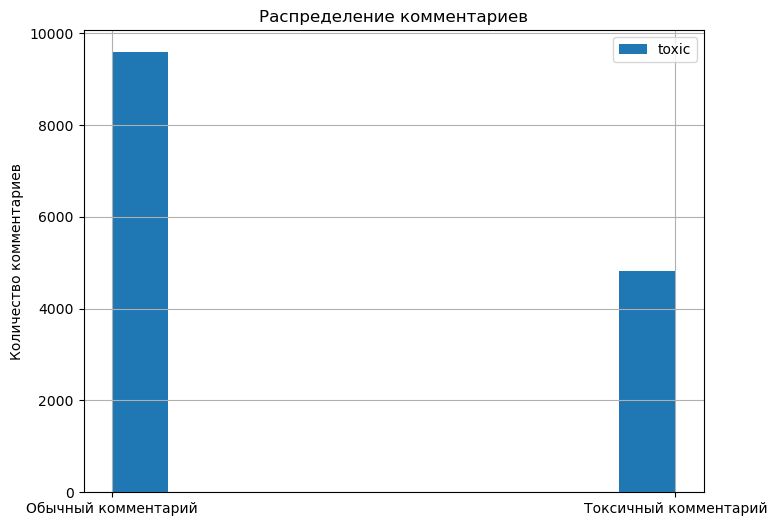

In [6]:
# поменяем тип toxic
df.toxic = df.toxic.astype('int32')
# распределение целевого признака
fig = plt.figure(figsize = (8, 6))
df.toxic.plot(kind='hist', grid = True, legend = True)
plt.ylabel('Количество комментариев')
plt.title('Распределение комментариев')
plt.xticks([0, 1], ['Обычный комментарий', 'Токсичный комментарий'])
plt.show()

In [7]:
# наблюдается дизбаланс классов
df.toxic.value_counts()

0    9586
1    4826
Name: toxic, dtype: int64

In [8]:
# пример токсичных комментариев
for ind, val in df.head(10).iterrows():
    if val.toxic == 1:
        print(val.comment)

Верблюдов-то за что? Дебилы, бл...

Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Собаке - собачья смерть

Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

тебя не убедил 6-страничный пдф в том, что Скрипалей отравила Россия? Анализировать и думать пытаешься? Ватник что ли?)

Для каких стан является эталоном современная система здравоохранения РФ? Для Зимбабве? Ты тупой? хохлы

УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РАЗВОРУЮТ КАК ВСЕГДА! УЖЕ ТРЕЩИНАМИ ПОШ Л! ТУПЫЕ КИТАЗЫ НЕ МОГУТ НИЧЕГО НОРМАЛЬНО СДЕЛАТЬ!

Ебать тебя разносит, шизик.

Обосрался, сиди обтекай



In [9]:
# пример нормальных комментариев
for ind, val in df.head(30).iterrows():
    if val.toxic == 0:
        print(val.comment)

В шапке были ссылки на инфу по текущему фильму марвел. Эти ссылки были заменены на фразу Репортим брипидора, игнорируем его посты. Если этого недостаточно, чтобы понять, что модератор абсолютный неадекват, и его нужно лишить полномочий, тогда эта борда пробивает абсолютное дно по неадекватности.

Почитайте посты у этого автора,может найдете что нибудь полезное. Надеюсь помог) https: pikabu.ru story obyichnyie budni dezsluzhbyi 4932098

Про графику было обидно) я так то проходил все серии гта со второй части по пятую, кроме гта 4. И мне не мешала графика ни в одной из частей. На компе у меня было куча видеокарт. Начиная с 32мб RIVA TNT и заканчивая 2Гб 560Ti на которой я спокойно играю который год в танки, гта5, ведьмака3 купил на распродаже и начал проходить. Да, не на ультрах. С пониженными текстурами. И не мешает. Я не понимаю дрочева на графике, требовать графику уровня плойки 4 минимум. Мне надо чтобы глаза не резало, только и всего. По поводу управления, мне не хватает переходника

In [10]:
# создадим копию df
df_copy = df.copy()
# разделим данные в пропорци 3:1
train, test = train_test_split(df, test_size = 0.25, random_state = 12345)
# размерность train и test
print(f'Расзмерность train: {train.shape}')
print(f'Расзмерность test: {test.shape}')

Расзмерность train: (10809, 2)
Расзмерность test: (3603, 2)


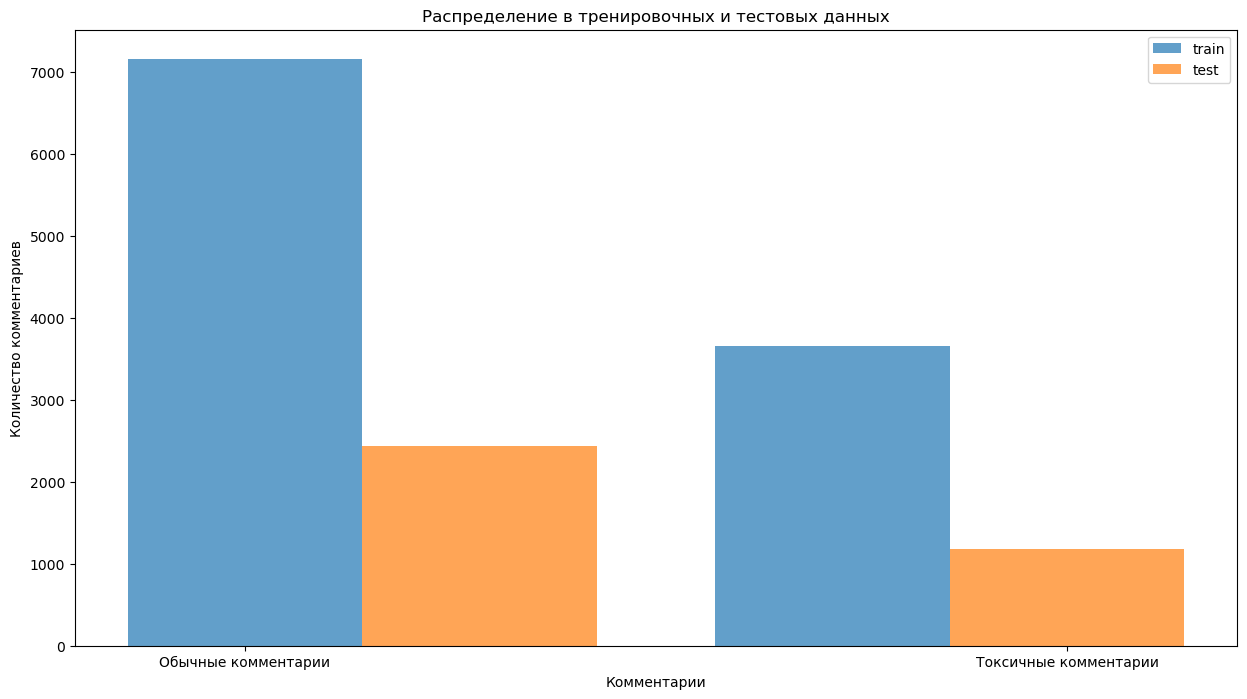

In [11]:
# Объединение данных train и test
all_data = [train.toxic, test.toxic]

plt.figure(figsize=(15, 8))
plt.hist(all_data, bins=2, alpha=0.7, label=['train', 'test'])

plt.xlabel('Комментарии')
plt.ylabel('Количество комментариев')
plt.title('Распределение в тренировочных и тестовых данных')
plt.xticks([0.15, 0.85], ['Обычные комментарии', 'Токсичные комментарии'])
plt.legend()

plt.show()

In [12]:
russian_stop_words = nltk_stopwords.words('russian')
m = Mystem()
def prep_text(sentence: str):
    tokens = word_tokenize(sentence, language="russian")
    tokens = [i for i in tokens if i not in string.punctuation]
    tokens = [i for i in tokens if i.lower() not in russian_stop_words]
    tokens = [m.lemmatize(i)[0] for i in tokens]
    return tokens
prep_text('Верблюдов-то за что? Дебилы, бл...')

['верблюд', 'дебил', 'бл', '...']

In [13]:
# наглядный пример преобразования текста
for sen in df.head(5).comment:
    print('------------------------------------------------------')
    print(f'Исходный текст: {sen}')
    print(f'Преобразованный: {" ".join(prep_text(sen))}')
    print('------------------------------------------------------')

------------------------------------------------------
Исходный текст: Верблюдов-то за что? Дебилы, бл...

Преобразованный: верблюд дебил бл ...
------------------------------------------------------
------------------------------------------------------
Исходный текст: Хохлы, это отдушина затюканого россиянина, мол, вон, а у хохлов еще хуже. Если бы хохлов не было, кисель их бы придумал.

Преобразованный: хохол это отдушина затюканый россиянин мол вон хохлов плохо хохлов кисель придумывать
------------------------------------------------------
------------------------------------------------------
Исходный текст: Собаке - собачья смерть

Преобразованный: собака собачий смерть
------------------------------------------------------
------------------------------------------------------
Исходный текст: Страницу обнови, дебил. Это тоже не оскорбление, а доказанный факт - не-дебил про себя во множественном числе писать не будет. Или мы в тебя верим - это ты и твои воображаемые друзья?

Пре

In [14]:
%%time
vectorizer = TfidfVectorizer(tokenizer=lambda x: prep_text(x))
# создание признаков
features_train = vectorizer.fit_transform(train.comment)
target_train = train.toxic

C:\Users\kil_a\AppData\Roaming\Python\Python310\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [15]:
# baseline
model = LogisticRegression(class_weight = 'balanced', random_state = 12345)
model.fit(features_train, target_train)

NameError: name 'features_train' is not defined

In [ ]:
%%time
# создание пайплайна
m = Mystem()
model_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: prep_text(x))),
    ("model", LogisticRegression(class_weight = 'balanced', random_state=12345))
]
)
# обучение пайплайна
model_pipeline.fit(train["comment"], train["toxic"])

In [ ]:
model_pipeline.predict(["Привет, у меня все нормально, как дела у тебя? Cлышал ты недавно купил маме новый дом?"])

In [ ]:
model_pipeline.predict(["А ты в край не ахуел ли случаем?"])

In [ ]:
precision = precision_score(y_true=test["toxic"], y_pred=model_pipeline.predict(test["comment"]))

In [ ]:
recall = recall_score(y_true=test["toxic"], y_pred=model_pipeline.predict(test["comment"]))


In [ ]:
prec, rec, thresholds = precision_recall_curve(y_true=test["toxic"], probas_pred=model_pipeline.predict_proba(test["comment"])[:, 1])

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(rec, prec, marker='o')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [ ]:
np.where(prec > 0.95)

In [ ]:
thresholds[3183]

In [ ]:
precision_score(y_true=test["toxic"], y_pred=model_pipeline.predict_proba(test["comment"])[:, 1] > thresholds[3184])

In [ ]:
recall_score(y_true=test["toxic"], y_pred=model_pipeline.predict_proba(test["comment"])[:, 1] > thresholds[3184])

In [ ]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: prep_text(x))),
    ("model",
     GridSearchCV(
        LogisticRegression(class_weight = 'balanced', random_state=12345),
        param_grid={
            'C': np.arange(0.1, 1.1, 0.1),
            'penalty': ['l1', 'l2']
            },
        cv=3,
        verbose=4,
        scoring = 'f1'
        )
    )
])


In [ ]:
grid_pipeline.fit(train["comment"], train["toxic"])

In [ ]:
model_pipeline_final = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: prep_text(x))),
    ("model", LogisticRegression(C = 1, penalty = 'l2', class_weight = 'balanced', random_state=12345))
]
)
# обучение пайплайна
model_pipeline_final.fit(train["comment"], train["toxic"])

In [ ]:
prec_c_1, rec_c_1, thresholds_c_1 = precision_recall_curve(y_true=test["toxic"], probas_pred=model_pipeline_final.predict_proba(test["comment"])[:, 1])

In [ ]:
np.where(prec_c_1 > 0.95)

In [ ]:
precision_score(y_true=test["toxic"], y_pred=model_pipeline_final.predict_proba(test["comment"])[:, 1] > thresholds_c_1[3183])

In [ ]:
recall_score(y_true=test["toxic"], y_pred=model_pipeline_final.predict_proba(test["comment"])[:, 1] > thresholds_c_1[3183])